In [1]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray
from tqdm.notebook import tqdm
%matplotlib inline

#### Set. Diretório

In [2]:
os.chdir("E:/ML_RS/1100")

### Gama

In [3]:
column_names = 'X Y FIDUCIAL GPSALT BARO ALTURA MDT CTB KB UB THB UUP LIVE_TIME COSMICO TEMP CTCOR KCOR UCOR THCOR CTEXP KPERC eU eTh THKRAZAO UKRAZAO UTHRAZAO LONGITUDE LATITUDE DATA HORA'.split(' ')
column_names

['X',
 'Y',
 'FIDUCIAL',
 'GPSALT',
 'BARO',
 'ALTURA',
 'MDT',
 'CTB',
 'KB',
 'UB',
 'THB',
 'UUP',
 'LIVE_TIME',
 'COSMICO',
 'TEMP',
 'CTCOR',
 'KCOR',
 'UCOR',
 'THCOR',
 'CTEXP',
 'KPERC',
 'eU',
 'eTh',
 'THKRAZAO',
 'UKRAZAO',
 'UTHRAZAO',
 'LONGITUDE',
 'LATITUDE',
 'DATA',
 'HORA']

#### Importando dados N-S

In [4]:
gamma_line = pd.read_csv('E:/ML_RS/1100/1100_GamaLine.XYZ', 
                    sep='\s+', names=column_names,skiprows= 11, 
                       usecols='LATITUDE LONGITUDE CTEXP KPERC eU eTh'.split(' '),
                       low_memory=False)
gamma_line.head(5) # This shows the first 5 entries 

,CTEXP,KPERC,eU,eTh,LONGITUDE,LATITUDE
0,3.99,0.33,1.82,8.04,-54.756936,-29.678923
1,4.00,0.34,1.41,8.92,-54.756886,-29.678335
2,4.02,0.40,1.15,9.32,-54.756831,-29.677748
3,4.01,0.48,1.09,8.97,-54.756777,-29.677161
4,3.89,0.54,1.21,7.95,-54.756722,-29.676573


### Retirando valores nan e dummies

In [5]:
for var in ['CTEXP', 'KPERC', 'eU', 'eTh']:
    
    var_array = gamma_line[var].values
    
    # replace dummies '*' with nan values
    var_array = np.where(var_array == '*', np.nan, var_array)

    # array float64
    var_array = np.array(var_array, dtype='float64')
    
    dummies = np.where(np.isnan(var_array) == True, 1, 0)
    
    #fillnan with mean
    var_array = np.nan_to_num(var_array, nan=np.nanmean(var_array))
    gamma_line[var] = var_array

In [6]:
gamma_line.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2297201 entries, 0 to 2297200
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   CTEXP      float64
 1   KPERC      float64
 2   eU         float64
 3   eTh        float64
 4   LONGITUDE  float64
 5   LATITUDE   float64
dtypes: float64(6)
memory usage: 105.2 MB


### Outliers

In [7]:
def remove_outliers(var_array):
    # interquantile range
    Q1 = np.percentile(var_array, 25) 
    Q3 = np.percentile(var_array, 75) 
    IQR = Q3 - Q1
    
    print(f'with outliers - min:{np.min(var_array):.3f} / max:{np.max(var_array):.3f}')

    # superior limite
    RPS = np.percentile(var_array, 95) # 95th percentile
    var_array = np.where(var_array > Q3 + 1.5*IQR, RPS, var_array)
    
    # inferior limite
    RPI = np.percentile(var_array, 5) # 5th percentile
    var_array = np.where(var_array < Q1 - 1.5*IQR, RPI, var_array)
    
    print(f'without outliers - min:{np.min(var_array):.3f} / max:{np.max(var_array):.3f}')
    
    return var_array

In [8]:
for var in ['CTEXP', 'KPERC', 'eU', 'eTh']:
    print(f'----------- {var} ------------')
    gamma_line[var] = remove_outliers(gamma_line[var].values)

----------- CTEXP ------------
with outliers - min:-3.550 / max:53.470
without outliers - min:-2.800 / max:15.430
----------- KPERC ------------
with outliers - min:-3.090 / max:18.060
without outliers - min:-2.180 / max:5.520
----------- eU ------------
with outliers - min:-8.860 / max:26.300
without outliers - min:-0.740 / max:3.420
----------- eTh ------------
with outliers - min:-3.520 / max:112.670
without outliers - min:-3.520 / max:24.200


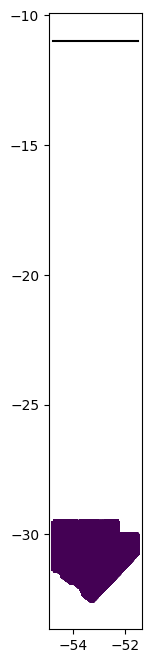

In [9]:
plt.figure(figsize=(8, 8))
plt.scatter(gamma_line.LONGITUDE, gamma_line.LATITUDE, marker='+', c=dummies, s=1)
plt.plot([gamma_line.LONGITUDE.min(), gamma_line.LONGITUDE.max()], [-11., -11.], color='k')
plt.axis('scaled')
plt.show()

### Clip

In [10]:
clip_1 = (gamma_line.LATITUDE <= -30.5)
clip_2 = (gamma_line.LATITUDE >= -31.0)
clip_3 = (gamma_line.LONGITUDE >= -54.0)
clip_4 = (gamma_line.LONGITUDE <= -53.5)
clip = np.where(clip_1 & clip_2 & clip_3  & clip_4)

shape = gamma_line.shape
# clip data
gamma_line = gamma_line.loc[clip]
print('shapes:', shape, gamma_line.shape)

shapes: (2297201, 6) (79751, 6)


In [11]:
gamma_line.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CTEXP,79751.0,6.121924,2.681824,-0.950000,4.620000,5.900000,7.360000,15.430000
KPERC,79751.0,2.006431,0.930865,-0.280000,1.360000,1.970000,2.610000,5.520000
eU,79751.0,1.087157,0.743972,-0.740000,0.600000,0.960000,1.410000,3.420000
eTh,79751.0,8.319655,4.351243,-2.330000,5.820000,7.640000,9.900000,24.200000
LONGITUDE,79751.0,-53.748462,0.144408,-53.999998,-53.873355,-53.748002,-53.623114,-53.500002
LATITUDE,79751.0,-30.750224,0.144301,-30.999988,-30.875190,-30.750432,-30.625372,-30.500015


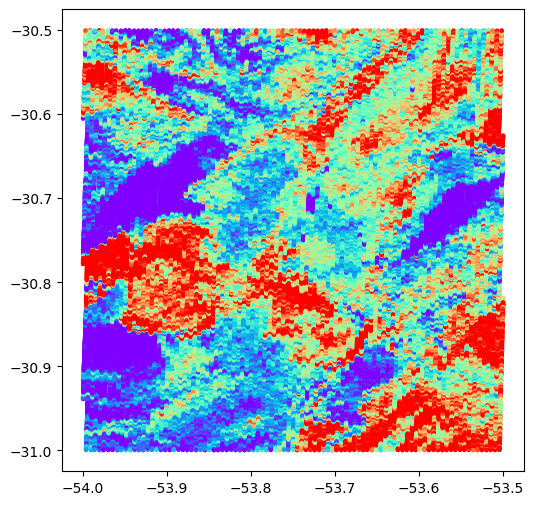

In [12]:
plt.figure(figsize=(6, 6))
plt.scatter(gamma_line.LONGITUDE, gamma_line.LATITUDE, c=gamma_line.KPERC, cmap='rainbow', s=5,
           vmin=np.percentile(gamma_line.KPERC, 10), vmax=np.percentile(gamma_line.KPERC, 90))

plt.axis('scaled')
plt.show()

### Importando dados L-O

In [13]:
gamma_tie = pd.read_csv('E:/ML_RS/1100/1100_GamaTie.XYZ', 
                       sep='\s+', names=column_names,skiprows=11, 
                       usecols='LATITUDE LONGITUDE CTEXP KPERC eU eTh'.split(' '),
                       low_memory=False)
gamma_tie.head(5) # This shows the first 5 entries 

,CTEXP,KPERC,eU,eTh,LONGITUDE,LATITUDE
0,5.37,0.79,1.72,10.67,-53.151640,-32.507826
1,5.33,0.90,1.38,10.71,-53.152421,-32.507783
2,5.33,1.00,1.21,10.57,-53.153201,-32.507743
3,5.40,1.09,1.28,10.18,-53.153981,-32.507709
4,5.51,1.14,1.58,9.63,-53.154759,-32.507681


#### Dealing with dummies and nan values

In [14]:
for var in ['CTEXP', 'KPERC', 'eU', 'eTh']:
    
    var_array = gamma_tie[var].values
    
    # replace dummies '*' with nan values
    var_array = np.where(var_array == '*', np.nan, var_array)

    # array float64
    var_array = np.array(var_array, dtype='float64')
    
    dummies = np.where(np.isnan(var_array) == True, 1, 0)
    
    #fillnan with mean
    var_array = np.nan_to_num(var_array, nan=np.nanmean(var_array))
    gamma_tie[var] = var_array

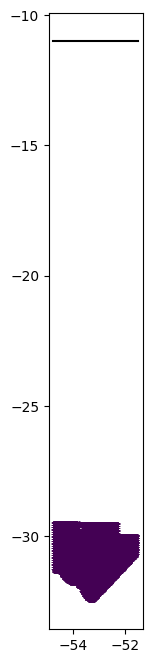

In [15]:
plt.figure(figsize=(8, 8))
plt.scatter(gamma_tie.LONGITUDE, gamma_tie.LATITUDE, marker='+', c=dummies, s=1)
plt.plot([gamma_tie.LONGITUDE.min(), gamma_tie.LONGITUDE.max()], [-11., -11.], color='k')
plt.axis('scaled')
plt.show()

In [16]:
for var in ['CTEXP', 'KPERC', 'eU', 'eTh']:
    print(f'----------- {var} ------------')
    gamma_tie[var] = remove_outliers(gamma_tie[var].values)

----------- CTEXP ------------
with outliers - min:-0.970 / max:44.710
without outliers - min:-0.970 / max:15.280
----------- KPERC ------------
with outliers - min:-0.450 / max:7.130
without outliers - min:-0.450 / max:5.460
----------- eU ------------
with outliers - min:-2.230 / max:18.620
without outliers - min:-1.120 / max:3.860
----------- eTh ------------
with outliers - min:-2.480 / max:83.660
without outliers - min:-2.480 / max:22.350


In [17]:
clip_1 = (gamma_tie.LATITUDE <= -30.5)
clip_2 = (gamma_tie.LATITUDE >= -31.0)
clip_3 = (gamma_tie.LONGITUDE >= -54.0)
clip_4 = (gamma_tie.LONGITUDE <= -53.5)
clip = np.where(clip_1 & clip_2 & clip_3  & clip_4)

shape = gamma_tie.shape
# clip data
gamma_tie = gamma_tie.loc[clip]
print('shapes:', shape, gamma_tie.shape)

shapes: (103891, 6) (3788, 6)


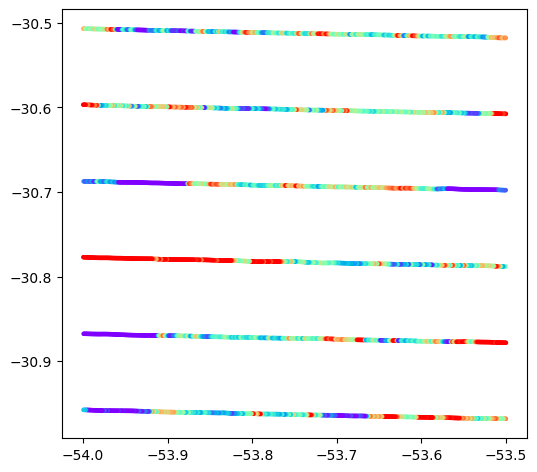

In [18]:
plt.figure(figsize=(6, 6))
plt.scatter(gamma_tie.LONGITUDE, gamma_tie.LATITUDE, c=gamma_tie.KPERC, cmap='rainbow', s=5,
           vmin=np.percentile(gamma_tie.KPERC, 10), vmax=np.percentile(gamma_tie.KPERC, 90))

plt.axis('scaled')
plt.show()

In [19]:
gamma_data = pd.concat([gamma_line, gamma_tie], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=False)
print(gamma_data.shape)
gamma_data.head(3)

(83539, 6)


,CTEXP,KPERC,eU,eTh,LONGITUDE,LATITUDE
0,1.82,0.62,0.24,2.52,-53.999969,-30.605109
1,1.44,0.66,-0.04,1.67,-53.999935,-30.604513
2,1.00,0.57,-0.16,0.84,-53.999900,-30.603918


In [20]:
from shapely import geometry
# EPSG:4674
crs = "+proj=longlat +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +no_defs"

# create geodataframe
gamma_data['geometry'] = gpd.points_from_xy(gamma_data.LONGITUDE, gamma_data.LATITUDE)
gamma_data = gpd.GeoDataFrame(gamma_data, geometry='geometry', crs=crs)
gamma_data.head()

,CTEXP,KPERC,eU,eTh,LONGITUDE,LATITUDE,geometry
0,1.82,0.62,0.24,2.52,-53.999969,-30.605109,POINT (-53.99997 -30.60511)
1,1.44,0.66,-0.04,1.67,-53.999935,-30.604513,POINT (-53.99994 -30.60451)
2,1.00,0.57,-0.16,0.84,-53.999900,-30.603918,POINT (-53.99990 -30.60392)
3,0.85,0.46,0.02,0.49,-53.999862,-30.603323,POINT (-53.99986 -30.60332)
4,1.34,0.48,0.49,1.03,-53.999823,-30.602729,POINT (-53.99982 -30.60273)


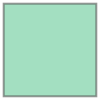

In [21]:
multipoints = geometry.MultiPoint(gamma_data['geometry'])
bounds = multipoints.envelope
bounds

In [22]:
# export bounds
gpd.GeoSeries(bounds).to_file('E:/ML_RS/1100/bounds.gpkg', 'GPKG')

### Interpolation

In [23]:
def nynx(cellsize, coords):
    
    cellsize = cellsize/111.139e3 #[meters to degrees]
    xmin, ymin = coords[0], coords[1]
    xmax, ymax = coords[2], coords[3]
    nx = int(np.around((xmax-xmin)/cellsize, 2))
    ny = int(np.around((ymax-ymin)/cellsize, 2))
    
    return cellsize, ny, nx, xmin, ymin, xmax, ymax

In [24]:
coords = gpd.GeoSeries(bounds).geometry.bounds
print(coords)

        minx       miny       maxx       maxy
0 -53.999998 -30.999988 -53.500002 -30.500015


In [25]:
cellsize = 125 #[meters]
cellsize, ny, nx, xmin, ymin, xmax, ymax = nynx(cellsize, coords.iloc[0, :].values)
print(cellsize, ny, nx)

0.0011247176958583396 444 444


In [26]:
# create a grid
yi = np.linspace(ymin+cellsize, ymax-cellsize, ny-2)
xi = np.linspace(xmin+cellsize, xmax-cellsize, nx-2)
ny = ny-2
nx = nx-2

x, y = np.meshgrid(xi, yi)
print(x.shape, y.shape)

(442, 442) (442, 442)


In [27]:
import harmonica
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from tqdm import tqdm

C:\Users\Matias\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [39]:
from scipy.interpolate import griddata

gamma_vars ={}
x = np.linspace(min(gamma_data.LONGITUDE.values), max(gamma_data.LONGITUDE.values), nx+1)
y = np.linspace(min(gamma_data.LATITUDE.values), max(gamma_data.LATITUDE.values), ny+1)
grid_x, grid_y = np.meshgrid(x, y)

for var in tqdm(['CTEXP', 'KPERC', 'eU', 'eTh']):
    points = np.array([gamma_data.LONGITUDE.values, gamma_data.LATITUDE.values]).T
    values = gamma_data[var].values
    img = griddata(points, values, (grid_x, grid_y), method='nearest') #nearest , linear ou cubic
    gamma_vars[var] = img

100%|██████████| 4/4 [00:01<00:00,  3.17it/s]


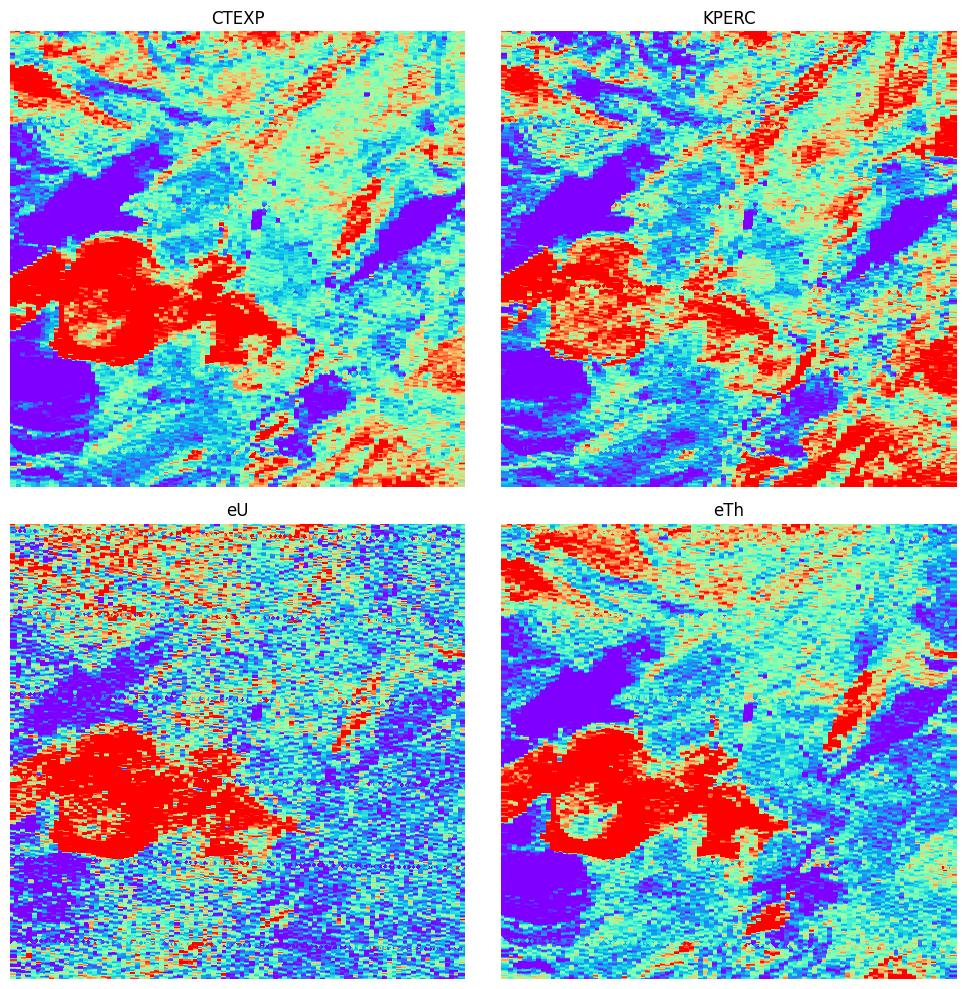

In [40]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
ax = ax.flatten()

for i, var in enumerate(['CTEXP', 'KPERC', 'eU', 'eTh']):
    vmin_var = np.percentile(gamma_vars[var], 10)
    vmax_var = np.percentile(gamma_vars[var], 90)
    
    ax[i].pcolormesh(x, y, gamma_vars[var], shading='auto',
                     vmin=vmin_var, vmax=vmax_var, cmap='rainbow')
    
    ax[i].set_aspect(1)
    ax[i].axis('off')
    ax[i].set_title(var)
    
plt.tight_layout()
plt.show()


### Original

### GPT

In [41]:
lon_data = np.array([-53.999998, -53.500002])  #  longitude data
lat_data = np.array([-30.999988 , -30.500015])  #  latitude data
some_data = np.array([gamma_vars])  # Main data array


In [43]:
import xarray as xr
import numpy as np

# Example data with correct integer number of samples
num_lon_points = 108  # Adjusted to an integer
num_lat_points = 60   # Adjusted to an integer

lon_data = np.linspace(-53.999998, -53.500002, num_lon_points)
lat_data = np.linspace(-30.999988 , -30.500015, num_lat_points)
data = np.random.rand(num_lat_points, num_lon_points)  # Example 2D data

# Example gamma_vars dictionary (assuming it contains the required arrays)
gamma_vars = {
    'CTEXP': np.random.rand(num_lat_points, num_lon_points),
    'KPERC': np.random.rand(num_lat_points, num_lon_points),
    'eU': np.random.rand(num_lat_points, num_lon_points),
    'eTh': np.random.rand(num_lat_points, num_lon_points),
}

# Define variables, coordinates, and attributes
vars_dict = {
    'TC': (['y', 'x'], gamma_vars['CTEXP'], {'variable': 'Total Count', 'unit': 'nGy/h'}),
    'Kperc': (['y', 'x'], gamma_vars['KPERC'], {'variable': 'Potassium Concentration', 'unit': '%'}),
    'eU': (['y', 'x'], gamma_vars['eU'], {'variable': 'Equivalent Uranium', 'unit': 'ppm'}),
    'eTh': (['y', 'x'], gamma_vars['eTh'], {'variable': 'Equivalent Thorium', 'unit': 'ppm'}),
}

coords = {
    'lon': (['x'], lon_data),
    'lat': (['y'], lat_data)
}

attrs = {
    'description': 'Geoscientific data from Lavras do Sul, RS, Brazil.'
}



In [44]:
# Create the dataset
dset = xr.Dataset(vars_dict, coords=coords, attrs=attrs)
print(dset)


<xarray.Dataset> Size: 209kB
Dimensions:  (y: 60, x: 108)
Coordinates:
    lon      (x) float64 864B -54.0 -54.0 -53.99 -53.99 ... -53.51 -53.5 -53.5
    lat      (y) float64 480B -31.0 -30.99 -30.98 -30.97 ... -30.52 -30.51 -30.5
Dimensions without coordinates: y, x
Data variables:
    TC       (y, x) float64 52kB 0.2294 0.6403 0.3274 ... 0.6672 0.6124 0.6369
    Kperc    (y, x) float64 52kB 0.4029 0.0906 0.7056 ... 0.6616 0.827 0.3844
    eU       (y, x) float64 52kB 0.7732 0.8142 0.8126 ... 0.08383 0.9386 0.6542
    eTh      (y, x) float64 52kB 0.1995 0.8483 0.7324 ... 0.9905 0.7291 0.2995
Attributes:
    description:  Geoscientific data from Lavras do Sul, RS, Brazil.


In [45]:
# Convert to DataFrame
df = dset.to_dataframe().reset_index()

# Save to CSV
df.to_csv('geoscientific_data.csv', index=False)

print('CSV file created successfully!')

CSV file created successfully!


In [46]:
dset = xarray.Dataset(vars_dict, coords, attrs)
dset

<xarray.Dataset> Size: 209kB
Dimensions:  (y: 60, x: 108)
Coordinates:
    lon      (x) float64 864B -54.0 -54.0 -53.99 -53.99 ... -53.51 -53.5 -53.5
    lat      (y) float64 480B -31.0 -30.99 -30.98 -30.97 ... -30.52 -30.51 -30.5
Dimensions without coordinates: y, x
Data variables:
    TC       (y, x) float64 52kB 0.2294 0.6403 0.3274 ... 0.6672 0.6124 0.6369
    Kperc    (y, x) float64 52kB 0.4029 0.0906 0.7056 ... 0.6616 0.827 0.3844
    eU       (y, x) float64 52kB 0.7732 0.8142 0.8126 ... 0.08383 0.9386 0.6542
    eTh      (y, x) float64 52kB 0.1995 0.8483 0.7324 ... 0.9905 0.7291 0.2995
Attributes:
    description:  Geoscientific data from Lavras do Sul, RS, Brazil.

In [47]:
def export_tif(ds, crs, path):

    import rasterio
    import rioxarray
    ds.rio.set_crs(crs, inplace=True)
    ds.rio.to_raster(path, driver='GTiff')
    
    x = ds['lon'].data
    y = ds['lat'].data
    src = rasterio.open(path)
    # get meta dict
    meta = src.meta

    # calculate pixel size
    pixel_size = np.diff(x).min()

    # add new affine
    meta['transform'] = rasterio.Affine(float(pixel_size), float(0.0), x.min(),
                    0.0, float(-pixel_size), float(y.max()))

    # export to tiff
    with rasterio.open(path, 'w', **meta) as raster:
        # If array is in  (y, x, z) order (cols, rows, bands)
        source = np.flip(src.read(), axis=1)
        raster.write(source)

In [48]:
# Save dataset to NetCDF using netcdf4 engine
dset.to_netcdf(path='E:/ML_RS/1100/dset_RS.nc', mode='w', format='NETCDF4', engine='netcdf4')



In [49]:

export_tif(dset, "EPSG:4326", 'E:/ML_RS/1100/gamma.tiff')# WGS84: 4326  SIRGAS 2000: 4674
    


CPLE_AppDefinedError: Deleting E:/ML_RS/1100/gamma.tiff failed: Permission denied

### Mag Data

In [56]:
column_names = 'X Y FIDUCIAL GPSALT BARO ALTURA MDT MAGBASE MAGBRU MAGCOM MAGCOR MAGNIV MAGMIC MAGIGRF IGRF LONGITUDE LATITUDE DATA HORA'.split(' ')
column_names


['X',
 'Y',
 'FIDUCIAL',
 'GPSALT',
 'BARO',
 'ALTURA',
 'MDT',
 'MAGBASE',
 'MAGBRU',
 'MAGCOM',
 'MAGCOR',
 'MAGNIV',
 'MAGMIC',
 'MAGIGRF',
 'IGRF',
 'LONGITUDE',
 'LATITUDE',
 'DATA',
 'HORA']

### Dados N-S

In [57]:
mag_line = pd.read_csv('E:/ML_RS/1100/1100_MagLine.XYZ', 
                      sep='\s+', names=column_names,skiprows=11, 
                       usecols=['LATITUDE', 'LONGITUDE', 'MAGIGRF'],
                       low_memory=True)
mag_line.head(3) 

,MAGIGRF,LONGITUDE,LATITUDE
0,22624.417,22612.512,-17.703
1,22624.365,22612.409,-17.829
2,22624.290,22612.298,-17.962


### Dummies

In [58]:
var_array = mag_line['MAGIGRF']
    
if np.where(var_array == '*')[0].size > 0:
    # replace dummies '*' with nan values
    var_array = np.where(var_array == '*', np.nan, var_array)

# array float64
var_array = np.array(var_array, dtype='float64')
    
dummies = np.where(np.isnan(var_array) == True, 1, 0)
    
#fillnan with mean
var_array = np.nan_to_num(var_array, nan=np.nanmean(var_array))
mag_line['MAGIGRF'] = var_array

 ### Outliers

In [59]:
mag_line['MAGIGRF'] = remove_outliers(mag_line.MAGIGRF.values)


with outliers - min:21617.242 / max:23947.892
without outliers - min:22468.852 / max:22920.447


### Clip data

In [60]:
clip_1 = (mag_line.LATITUDE <= -30.5)
clip_2 = (mag_line.LATITUDE >= -31.0)
clip_3 = (mag_line.LONGITUDE >= -54.0)
clip_4 = (mag_line.LONGITUDE <= -53.5)
clip = np.where(clip_1 & clip_2 & clip_3  & clip_4)

shape = mag_line.shape
# clip data
mag_line = mag_line.loc[clip]
print('shapes:', shape, mag_line.shape)

shapes: (22944071, 3) (0, 3)


In [55]:
mag_line.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MAGIGRF,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LONGITUDE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LATITUDE,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Importing E-W data

In [ ]:

mag_tie = pd.read_csv('E:/ML_RS/1100/1100_MagTie.XYZ', 
                       sep='\s+', names=column_names,skiprows=11, 
                       usecols=['LATITUDE', 'LONGITUDE', 'MAGIGRF'])
mag_tie.head()

In [ ]:
var_array = mag_tie['MAGIGRF']
    
if np.where(var_array == '*')[0].size > 0:
    # replace dummies '*' with nan values
    var_array = np.where(var_array == '*', np.nan, var_array)

# array float64
var_array = np.array(var_array, dtype='float64')
    
dummies = np.where(np.isnan(var_array) == True, 1, 0)
    
#fillnan with mean
var_array = np.nan_to_num(var_array, nan=np.nanmean(var_array))
mag_tie['MAGIGRF'] = var_array

### Outliers

In [ ]:
mag_tie['MAGIGRF'] = remove_outliers(mag_tie.MAGIGRF.values)

### Clip data

In [ ]:
clip_1 = (mag_tie.LATITUDE <= -30.5)
clip_2 = (mag_tie.LATITUDE >= -31.0)
clip_3 = (mag_tie.LONGITUDE >= -54.0)
clip_4 = (mag_tie.LONGITUDE <= -53.5)
clip = np.where(clip_1 & clip_2 & clip_3  & clip_4)

shape = mag_tie.shape
# clip data
mag_line = mag_tie.loc[clip]
print('shapes:', shape, mag_tie.shape)

### Merge datasets

In [ ]:
mag_data = pd.concat([mag_line, 
                      mag_tie], axis=0, join='outer', ignore_index=True, keys=None,
          levels=None, names=None, verify_integrity=False, copy=False)
print(mag_data.shape)
mag_data.head(3)

### Interpolação

In [ ]:
from scipy.interpolate import griddata

# Assuming you have already defined x, y, and ny, nx (your grid coordinates and dimensions)
points = np.column_stack((mag_data['LONGITUDE'], mag_data['LATITUDE']))
values = mag_data['MAGIGRF']

# Interpolate onto the grid
resmag = griddata(points, values, (x.ravel(), y.ravel()), method='linear').reshape((ny, nx))


In [ ]:
import numpy as np
import verde as vd

# Assuming you have already defined x, y, ny, and nx
# (your grid coordinates and dimensions)

# Create a Verde gridder
gridder = vd.Spline()

# Fit the gridder to your data
gridder.fit((mag_data['LONGITUDE'], mag_data['LATITUDE']), mag_data['MAGIGRF'])

# Generate the interpolated grid
resmag = gridder.grid((x.ravel(), y.ravel()), data_names='MAGIGRF').reshape((ny, nx))

# Apply median filtering
resmag = ndimage.median_filter(resmag, size=3)

# Compute analytical signal and tilt
asa = vd.analytical_signal(x.ravel(), y.ravel(), resmag.ravel(), shape=(ny, nx)).reshape((ny, nx))
tilt = vd.tilt(x.ravel(), y.ravel(), resmag.ravel(), shape=(ny, nx)).reshape((ny, nx))


### MDT

In [ ]:
!pip install rasterio

In [ ]:
import fiona
with fiona.open("VETORES/bounds.gpkg", "r") as geopack:
    shapes = [feature["geometry"] for feature in geopack]